In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Inspecting the dataset

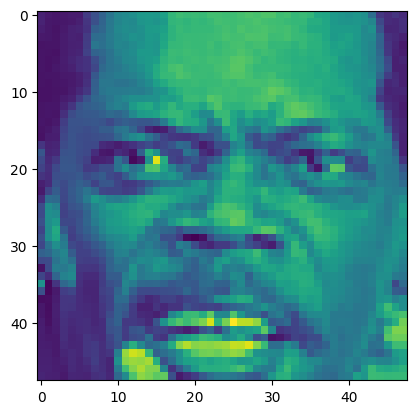

In [2]:
from PIL import Image
import requests
from io import BytesIO

image_bw = Image.open(r"C:\Coding\Emotion recognition\Data\Angry\10.png")
image_color = Image.open(r"C:\Coding\Emotion recognition\Data\Image.jpg")
plt.imshow(image_bw)
#displays pixel values as colors

# plt.axis("off")
#removes coordinate cluste

In [4]:
to_tensor = transforms.ToTensor()
image_bw_tensor = to_tensor(image_bw)
image_color_tensor = to_tensor(image_color)

print(image_bw_tensor.shape, image_bw_tensor.dtype)
print(image_color_tensor.shape, image_color_tensor.dtype)

torch.Size([1, 48, 48]) torch.float32
torch.Size([3, 408, 612]) torch.float32


In [5]:
from torchvision.datasets import ImageFolder

DATA_DIR = r"C:\Coding\Emotion recognition\Data"
#Load dataset from directory
dataset = ImageFolder(root=DATA_DIR)
#ImageFolder assumes that images are organized in subdirectories named after their classes
# Imagefolder looks at folder names, assigns each folder an interger label, and maps images to those labels based on their folder
"""
e.g.
Happy : 0
Sad : 1
...
"""

print(f"Number of samples : {len(dataset)}")
print(f"Classes : {dataset.classes}")

Number of samples : 59099
Classes : ['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']


Type:  <class 'PIL.Image.Image'>
Size (W, H): (48, 48)
Mode : RGB


(np.float64(-0.5), np.float64(47.5), np.float64(47.5), np.float64(-0.5))

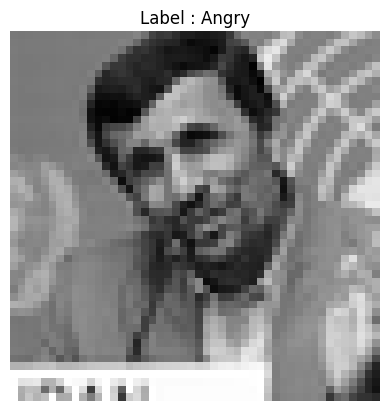

In [6]:
img, label = dataset[10]

print("Type: ", type(img))
print(f"Size (W, H): {img.size}")
print(f"Mode : {img.mode}")

plt.imshow(img, cmap="gray")
plt.title(f"Label : {dataset.classes[label]}")
plt.axis("off")

# Train/Validation Split

In [7]:
from torch.utils.data import random_split

train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
# 70% training, 30% validation

train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

len(train_dataset), len(val_dataset)

(41369, 17730)

# Define Transforms

### Transform Pipeline

In [8]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


"""
resize(...) : CNN models typically require fixed-size inputs, so resizing ensures all images conform to the expected input dimensions.

ToTensor(...) : Converts images to float32, scales pixel values to [0, 1], and rearranges dimensions to (C, H, W).

Normalize(...) : Aligns image data with the distribution of the dataset used to pre-train the CNN models, which helps in faster convergence and better performance.
"""

'\nresize(...) : CNN models typically require fixed-size inputs, so resizing ensures all images conform to the expected input dimensions.\n\nToTensor(...) : Converts images to float32, scales pixel values to [0, 1], and rearranges dimensions to (C, H, W).\n\nNormalize(...) : Aligns image data with the distribution of the dataset used to pre-train the CNN models, which helps in faster convergence and better performance.\n'

### Apply transform to train and val splits

In [9]:
train_dataset.dataset.transform = transform
val_dataset.dataset.transform = transform


Sanity check

In [10]:
img, label = train_dataset[0]
img.shape, img.min(), img.max()

(torch.Size([3, 224, 224]), tensor(-1.3130), tensor(2.6400))

# Dataloaders

In [11]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64 # Number of samples per batch

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Prevent learning order bias
    num_workers=4,  # Parallel data loading
    pin_memory=True  # Speed up data transfer to GPU, harmless if CUDA is on
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

Sanity Check

In [12]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

# Loading the pretrained model

In [13]:
from torchvision import models

model = models.mobilenet_v2(pretrained=True)
# Using the model "MobileNetV2" pretrained on ImageNet dataset

c:\Coding\Anaconda\envs\ml-gpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Coding\Anaconda\envs\ml-gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [15]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

in_features=1280 means : model give 1280 number of features the model has extracted from image before making a decision.
at the end, model will convert 224x224x3 image into one vector of length 1280

Here, out_feature = 1000 is 1000 because ImageNet has 1000 classes including dogs, cats, planes, bananas, etc.

We have only 5 classes that are our 5 emotions, so we'll change 1000 to 5.

In [16]:
import torch.nn as nn

NUM_CLASSES = 5  # Angry, Disgust, Fear, Happy, Sad

# Replace only the classifier with a new one for our specific task
model.classifier[1] = nn.Linear(
    in_features=1280,
    out_features=NUM_CLASSES,
    bias=True
)

nn = torch.nn : this is pytorch's module system for neural networks. Anything having parameters, participating in backprop, and learns lives in torch.nn

Sanity check

In [17]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=5, bias=True)
)

Okay, now we have successfully updated our output to 5.

Now we will train the model, but before that, we will need the features part of model to remain as it is as it recognises edges and all that will help in recognising the mood. So we will only have to train the classifier head, and make the feature's part remain as it is, so we will first freeze the features weights.

## Freezing the model's features part

In [18]:
for param in model.features.parameters():  # All weights in feature extractor
    param.requires_grad = False  # Pytorch stops computing gradients for these parameters, optimizer ignores them, weights stay unchanged.

Sanity check

In [19]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

features.0.0.weight False
features.0.1.weight False
features.0.1.bias False
features.1.conv.0.0.weight False
features.1.conv.0.1.weight False
features.1.conv.0.1.bias False
features.1.conv.1.weight False
features.1.conv.2.weight False
features.1.conv.2.bias False
features.2.conv.0.0.weight False
features.2.conv.0.1.weight False
features.2.conv.0.1.bias False
features.2.conv.1.0.weight False
features.2.conv.1.1.weight False
features.2.conv.1.1.bias False
features.2.conv.2.weight False
features.2.conv.3.weight False
features.2.conv.3.bias False
features.3.conv.0.0.weight False
features.3.conv.0.1.weight False
features.3.conv.0.1.bias False
features.3.conv.1.0.weight False
features.3.conv.1.1.weight False
features.3.conv.1.1.bias False
features.3.conv.2.weight False
features.3.conv.3.weight False
features.3.conv.3.bias False
features.4.conv.0.0.weight False
features.4.conv.0.1.weight False
features.4.conv.0.1.bias False
features.4.conv.1.0.weight False
features.4.conv.1.1.weight False
fea

## Move the model to GPU

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device  # device is just a label

device(type='cuda')

In [21]:
model = model.to(device)  # .to(device) moves physically moves tensors + parameters to the specified device

feature extractor stays frozen but still moves to gpu inference

## Define loss function

what loss does : Loss answers one question "How wrong was the model ?"

In [22]:
criterion = nn.CrossEntropyLoss()
# CrossEntropyLoss combines nn.LogSoftmax() and nn.NLLLoss() in one single class. i.e., it applies Softmax to the model outputs, compares them with the labels, and computes the loss and produces one scalar number.

## Define optimizer

Just to ensure we do not pass model.parameters() because that will waste memory and lose the clarity, we will explicitly pass classifier parameters

In [23]:
import torch.optim as optim

optimizer = optim.Adam(
    model.classifier.parameters(),  # Only optimize the classifier parameters
    lr=1e-3 # Learning rate
)

One forward pass sanity check.

Before training loops , we check data > model > output, if the shapes have lined up, and if gpu usage is correct

## Forward pass check

In [ ]:
# images, labels = next(iter(train_loader))

# images = images.to(device)
# labels = labels.to(device)

# outputs = model(images)

In [ ]:
# outputs

tensor([[ 3.5380e-01,  1.1352e-03, -6.8130e-02,  1.1903e-01, -1.4448e-01],
        [ 7.1477e-02, -7.4851e-01,  2.7621e-02, -6.3523e-02, -6.8241e-01],
        [ 3.9731e-01,  3.1461e-02, -1.6884e-01,  5.9638e-02,  2.7402e-01],
        [ 1.8810e-01,  2.5361e-01,  2.3815e-01, -1.4736e-01, -1.9315e-01],
        [ 6.1781e-01,  4.5060e-01,  3.6684e-01, -6.6034e-01, -6.3672e-01],
        [ 7.4274e-01,  2.6970e-01, -3.4338e-01,  7.2573e-02, -1.9509e-01],
        [-4.1241e-02, -3.9403e-01, -6.2505e-01, -1.9556e-01, -2.8439e-01],
        [ 7.0859e-02, -3.7671e-01, -3.1892e-01,  3.7150e-01, -5.1658e-01],
        [ 1.4404e-01, -2.3258e-01, -1.9774e-01,  2.0736e-01,  3.2720e-03],
        [ 2.3284e-01,  3.1748e-01,  2.6926e-02, -1.9206e-01, -6.2747e-01],
        [ 7.2198e-02, -3.9238e-01,  4.4107e-01,  7.0055e-02, -2.7715e-01],
        [ 3.3724e-01, -2.1313e-01, -1.4312e-01,  2.6959e-01, -5.3875e-01],
        [ 8.2022e-01,  3.6587e-01, -2.0268e-01,  1.9506e-01, -4.4981e-01],
        [ 7.4076e-01,  2.

# Training loops

what a training loop is : guess > check how wrong > adjust > repeat

In [ ]:
# EPOCHS = 3

# for epoch in range(EPOCHS):
    
#     model.train()  # Set model to training mode
#     running_loss = 0.0

#     for images, labels in train_loader:

#         images = images.to(device)
#         labels = labels.to(device)

#         optimizer.zero_grad()  # Clear previous gradients

#         outputs = model(images)  # Forward pass
#         loss = criterion(outputs, labels)  # Compute loss

#         loss.backward()  # Backpropagation
#         optimizer.step()  # Update weights

#         running_loss += loss.item()  # Accumulate loss

#     avg_loss = running_loss / len(train_loader)
#     print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}")

Epoch [1/3], Loss: 1.3233
Epoch [2/3], Loss: 1.2593
Epoch [3/3], Loss: 1.2483


The given decrease in loss means that the model is learning but not able to attain more accuracy.

The fix is NOT : more epochs, bigger batch, or more patience,

The fix IS : fine tuning.

# Fine-Tuning

### Step 1 : Unfreeze last feature block

In [27]:
for param in model.features.parameters():
    param.requires_grad = True

### Step 2 : Update optimizer

In [28]:
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr = 1e-4
)

Lower LR = stable fine-tuning

In [30]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

features.0.0.weight True
features.0.1.weight True
features.0.1.bias True
features.1.conv.0.0.weight True
features.1.conv.0.1.weight True
features.1.conv.0.1.bias True
features.1.conv.1.weight True
features.1.conv.2.weight True
features.1.conv.2.bias True
features.2.conv.0.0.weight True
features.2.conv.0.1.weight True
features.2.conv.0.1.bias True
features.2.conv.1.0.weight True
features.2.conv.1.1.weight True
features.2.conv.1.1.bias True
features.2.conv.2.weight True
features.2.conv.3.weight True
features.2.conv.3.bias True
features.3.conv.0.0.weight True
features.3.conv.0.1.weight True
features.3.conv.0.1.bias True
features.3.conv.1.0.weight True
features.3.conv.1.1.weight True
features.3.conv.1.1.bias True
features.3.conv.2.weight True
features.3.conv.3.weight True
features.3.conv.3.bias True
features.4.conv.0.0.weight True
features.4.conv.0.1.weight True
features.4.conv.0.1.bias True
features.4.conv.1.0.weight True
features.4.conv.1.1.weight True
features.4.conv.1.1.bias True
featu

### Step 3 : Training Again

In [ ]:
# EPOCHS = 3

# for epoch in range(EPOCHS):
    
#     model.train()  # Set model to training mode
#     running_loss = 0.0

#     for images, labels in train_loader:

#         images = images.to(device)
#         labels = labels.to(device)

#         optimizer.zero_grad()  # Clear previous gradients

#         outputs = model(images)  # Forward pass
#         loss = criterion(outputs, labels)  # Compute loss

#         loss.backward()  # Backpropagation
#         optimizer.step()  # Update weights

#         running_loss += loss.item()  # Accumulate loss

    # avg_loss = running_loss / len(train_loader)
    # print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}")

Epoch [1/3], Loss: 0.8620
Epoch [2/3], Loss: 0.5777
Epoch [3/3], Loss: 0.3760


# Validation process (Testing)

How validation is computed :
1. take a batch of validation images
2. run them through model
3. get outputs (logits)
4. Pick the highest score - predicted class
5. Compare with true label
6. Count correct predictions
7. Divide by total

No gradients

no weigh updates

no learning

In [31]:
def validate(model, val_loader, device):
    model.eval()  # Set model to evaluation mode

    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation, no learning during validation
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predicted class

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
    return accuracy

Now we'll write a code to validate accuracy of model after every epoch so that we'll understand if the model is increasing in accuracy or not, is it overfitting, should we stop early ...

In [ ]:
EPOCHS = 3

for epoch in range(EPOCHS):

    model.train()
    running_loss = 0.0

    for images, labels in train_loader:

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    val_acc = validate(model, val_loader, device)

    avg_loss = running_loss / len(train_loader)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}")

    print(f"Epoch [{epoch+1}/{EPOCHS}]\n", f"Loss: {avg_loss:.4f}\n" f"Validation Accuracy: {val_acc:.2f}%")